# Active Appearance Models with Menpo for Infrared Images

## Train Your AAM

### Settings AAM-Training

To train an Active Appearance Model (AAM) a database of images with a consistent number of labeled points per image is required. The path to this database should be specified below in ``IMAGE_PATH``. The labeled points should either be in a ``.pts`` or a ``.ljson`` file and the filetype has to be specified in ``LANDMARK_GROUP``. 
Afterwards a feature descriptor has to be selected:

 * ``no_op`` uses the raw image data
 * ``d_sift`` and ``fast_dsift`` are computing [dense sift features](https://pdfs.semanticscholar.org/ac08/4587faa2227e8e09a0d2b7803f60f23be1c1.pdf)
 * ``hog`` will compute the [histogram of oriented gradients](http://web.eecs.umich.edu/~silvio/teaching/EECS598_2010/slides/09_28_Grace.pdf)

At the end a scale and an image diagonal has to be choosed (recommended to use default parameters at the beginning)

In [6]:
def hog(pixels, mode='dense', algorithm='dalaltriggs', num_bins=9,
        cell_size=8, block_size=2, signed_gradient=True, l2_norm_clip=0.2,
        window_height=1, window_width=1, window_unit='blocks',
        window_step_vertical=1, window_step_horizontal=1,
        window_step_unit='pixels', padding=True, verbose=False):
   
    pixels = np.rollaxis(pixels, 0, len(pixels.shape))
    # Parse options
    if mode not in ['dense', 'sparse']:
        raise ValueError("HOG features mode must be either dense or sparse")
    if algorithm not in ['dalaltriggs', 'zhuramanan']:
        raise ValueError("Algorithm must be either dalaltriggs or zhuramanan")
    if num_bins <= 0:
        raise ValueError("Number of orientation bins must be > 0")
    if cell_size <= 0:
        raise ValueError("Cell size (in pixels) must be > 0")
    if block_size <= 0:
        raise ValueError("Block size (in cells) must be > 0")
    if l2_norm_clip <= 0.0:
        raise ValueError("Value for L2-norm clipping must be > 0.0")
    if mode == 'dense':
        if window_unit not in ['pixels', 'blocks']:
            raise ValueError("Window unit must be either pixels or blocks")
        window_height_temp = window_height
        window_width_temp = window_width
        if window_unit == 'blocks':
            window_height_temp = window_height * block_size * cell_size
            window_width_temp = window_width * block_size * cell_size
        if (window_height_temp < block_size * cell_size or
            window_height_temp > pixels.shape[0]):
            raise ValueError("Window height must be >= block size and <= "
                             "image height")
        if (window_width_temp < block_size*cell_size or
            window_width_temp > pixels.shape[1]):
            raise ValueError("Window width must be >= block size and <= "
                             "image width")
        if window_step_horizontal <= 0:
            raise ValueError("Horizontal window step must be > 0")
        if window_step_vertical <= 0:
            raise ValueError("Vertical window step must be > 0")
        if window_step_unit not in ['pixels', 'cells']:
            raise ValueError("Window step unit must be either pixels or cells")

    # Correct input image_data
    pixels = np.asfortranarray(pixels)
    pixels *= 255.

    # Dense case
    if mode == 'dense':
        # Iterator parameters
        if algorithm == 'dalaltriggs':
            algorithm = 1
            if window_unit == 'blocks':
                block_in_pixels = cell_size * block_size
                window_height = np.uint32(window_height * block_in_pixels)
                window_width = np.uint32(window_width * block_in_pixels)
            if window_step_unit == 'cells':
                window_step_vertical = np.uint32(window_step_vertical *
                                                 cell_size)
                window_step_horizontal = np.uint32(window_step_horizontal *
                                                   cell_size)
        elif algorithm == 'zhuramanan':
            algorithm = 2
            if window_unit == 'blocks':
                block_in_pixels = 3 * cell_size
                window_height = np.uint32(window_height * block_in_pixels)
                window_width = np.uint32(window_width * block_in_pixels)
            if window_step_unit == 'cells':
                window_step_vertical = np.uint32(window_step_vertical *
                                                 cell_size)
                window_step_horizontal = np.uint32(window_step_horizontal *
                                                   cell_size)
        iterator = WindowIterator(pixels, window_height, window_width,
                                  window_step_horizontal,
                                  window_step_vertical, padding)
    # Sparse case
    else:
        # Create iterator
        if algorithm == 'dalaltriggs':
            algorithm = 1
            window_size = cell_size * block_size
            step = cell_size
        else:
            algorithm = 2
            window_size = 3 * cell_size
            step = cell_size
        iterator = WindowIterator(pixels, window_size, window_size, step,
                                  step, False)
    # Print iterator's info
    if verbose:
        print(iterator)
    # Compute HOG
    hog_descriptor = iterator.HOG(algorithm, num_bins, cell_size, block_size,
                                  signed_gradient, l2_norm_clip, verbose)
    # TODO: This is a temporal fix
    # flip axis
    hog_descriptor = WindowIteratorResult(
        np.ascontiguousarray(np.rollaxis(hog_descriptor.pixels, -1)),
        hog_descriptor.centres)
    return hog_descriptor

from menpo.feature import ndfeature # you can import no_op and dsift as well (hog is best for imfrared images though)
IMAGE_PATH = "C:/Users/Mateusz/AppData/Local/Programs/Python/Python36/Scripts/inz/FaceDB_Snapshot_complete" # "/home/temp/schock/Infrared/Databases/FaceDB_Snapshot"
LANDMARK_GROUP = "LJSON" #or "PTS"
features = hog
scales = 1
diagonal = 100

# convert feature from 64 to 32 bit; has no impact on fitting precision but saves 50% memory
# thanks to the menpo team for the hint
# you should define the same for your other features if you use other features than hog in your code
@ndfeature
def float32_hog(x):
    return hog(x).astype(np.float32)

features = float32_hog

### Loading Images

With ``mio.import images`` we firstly import all images their corresponding landmarks in ``IMAGE_PATH``.
Afterwards we crop every image to its respective landmarks to ensure that the resulting image contains only the face.
The last step of loading the images is to convert them to greyscale if they are not already.
> #### Note: The landmark-files must have the same name as the corresponding image-files but with different file-exstensions 

In [427]:
from menpo import io as mio
from tqdm import tqdm

print("Importing images")
train_images = []

for i in tqdm(mio.import_images(IMAGE_PATH)):
    
    # Crop images to Landmarks --> only Face on resulting image
    i = i.crop_to_landmarks_proportion(0.1)
    
    # Convert multichannel images to greyscale
    if i.n_channels > 2:
        i = i.as_greyscale()
        
    train_images.append(i)

    
print("Succesfully imported %d Images" % len(train_images))


Importing images


  0%|                                                                                         | 0/2934 [00:00<?, ?it/s]c:\users\mateusz\appdata\local\programs\python\python36\lib\site-packages\menpo\io\input\landmark.py:422: MenpoDeprecationWarning: LJSON v2 is deprecated. export_landmark_file() will only save out LJSON v3 files. Please convert all LJSON files to v3 by importing into Menpo and re-exporting to overwrite the files.
  MenpoDeprecationWarning,
100%|██████████████████████████████████████████████████████████████████████████████| 2934/2934 [02:23<00:00, 20.42it/s]

Succesfully imported 2934 Images


### Training the AAM
The trainstage of an Active Appearance Model is almost only a PCA for each of the model parts (Shape Model and Appearance Model) and storing their results. Therefore the code for training an AAM is quite simple using the previous defined settings:

In [ ]:
from menpofit.aam import HolisticAAM as AAM
import numpy as np
print("Training AAM")
aam = AAM(
    train_images,
    group=LANDMARK_GROUP,
    verbose=True,
    holistic_features=features,
    scales=scales,
    diagonal = diagonal
)

##  Fitting from a trained AAM
### Creating an AAM-Fitter : LucasKanadeFitter
To fit images using the trained AAM a fitter is necessary. The fitter is a class cappable of the whole optimization procedure. 
As compositional gradient descent algorithms either the [Wiberg Inverse Compositional Gauss-Newton algorithm (WIC)](http://menpofit.readthedocs.io/en/stable/api/menpofit/aam/WibergInverseCompositional.html) or the [Simultaneous Inverse Compositional Gauss-Newton algorithm (SIC)](http://menpofit.readthedocs.io/en/stable/api/menpofit/aam/SimultaneousInverseCompositional.html) should be used [1](https://link.springer.com/article/10.1007%2Fs11263-016-0916-3).
With the parameters ``n_shape`` and ``n_appearance`` we can specify how many of the PCA-components should be used for the fitting process. Setting them to a float less between zero and one it defines the fraction of accuracy we want to achieve at the certain model. Setting it to an int greater than one it defines the number of components to be used. 

In [ ]:
from menpofit.aam import LucasKanadeAAMFitter as Fitter
from menpofit.aam import WibergInverseCompositional as WIC
from menpofit.aam import SimultaneousInverseCompositional as SIC

print("Creating Fitter")
fitter_alg = WIC # or SIC  --> Algorithm to be used by fitter
n_shape = 0.95 #  --> fraction of shape accuracy to remain (dimensionality reduction through PCA)
n_appearance = 0.95 #  --> fraction of appearance accuracy to remain (dimensionality reduction through PCA)

fitter = Fitter(aam=aam, 
                lk_algorithm_cls=fitter_alg,
                n_shape=n_shape, 
                n_appearance=n_appearance)

## Face Detection
To recieve a good result from our LucasKanadeAAMFitter we need to give it a bounding box of the face as initialization. This bounding box shows defines the position and scale of the AAM's initial shape.

To do so, we need to define a function which gets a list of faces and returns the bounding box of the first shape as [PointDirectedGraph](http://docs.menpo.org/en/stable/api/shape/PointDirectedGraph.html):

In [ ]:
import numpy as np
import menpo

def face_2_pointcloud(faces):
    if len(faces):
            face = np.array([faces[0].as_vector()[1], faces[0].as_vector()[0],
                             faces[0].range()[1], faces[0].range()[0]]).astype(np.uint16)
            print("Face detected. > ", face)
    else:
        face = np.array([0, 0, 0, 0]).astype(np.uint16)
        print("NO Face detected.")
    
    points = np.array([[face[1], face[0]],
                         [face[1]+face[3], face[0]],
                         [face[1]+face[3], face[0]+face[2]],
                         [face[1], face[0]+face[2]]])

    adjacency_matrix = np.array([[0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 1, 0]])

    return menpo.shape.PointDirectedGraph(points, adjacency_matrix)

Afterwards we load a pretrained [hog-facedetector](http://blog.dlib.net/2014/02/dlib-186-released-make-your-own-object.html) to detect the faces and return their bounding boxes:

> #### Note: The face detector has been trained on infrared images. To guarantee good performance on other image types it should be retrained 

In [19]:
import menpodetect
import dlib
HOG_PATH = "./hog_detector.svm"

print("Loading Face Detector")
face_detector = menpodetect.DlibDetector(dlib.simple_object_detector(HOG_PATH))

Loading Face Detector


Afterwards we load the test-image and detect it's face using the loaded face-detector and and the previously written function ``face_2_pointcloud`` will return us a bounding box as PointDirectedGraph:

In [39]:
TEST_IMG_PATH = "IMGT0003.PNG" # "/home/temp/schock/Infrared/Databases/IR_HPE_Colette/001/image_00000.png" 

print("Loading Test Image")
test_img = mio.import_image(TEST_IMG_PATH)

test_img = test_img.as_greyscale()

print("Detecting Face")
test_face_bb = face_2_pointcloud(face_detector(test_img))


Loading Test Image
Detecting Face
Face detected. >  [ 77 112 104 103]


### Fitting
Using the detected face's bounding box, we fit from the bounding box by invoking the fitters function ``fit_from_bb`` and passing it the loaded image and the bounding box. The argument ``max_iters=25`` defines the maximum number of compositional gradient descent iterations to be 25, which is usually a good tradeoff between performance and accuracy.

The achieved ``fitting_result`` can be visualized with ``fitting_result.view()``. To show the created figure the pyplot ``show`` function is necessary afterwards.

Fitting AAM


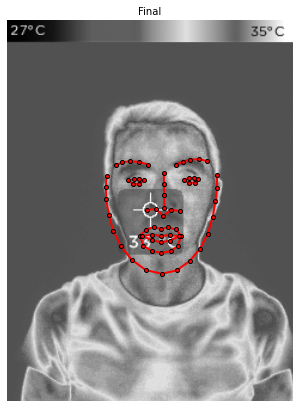

In [40]:
from matplotlib import pyplot as plt

print("Fitting AAM")
fitting_result = fitter.fit_from_bb(test_img, test_face_bb, max_iters=25)

fitting_result.view()
plt.show()

## Emotion Detection
### Loading the pretrained classifier
To classify the face's emotion we provide a pretrained classifier. To load this classifier the following function tries to load it using ``joblib`` and switches back to loading it with ``pickle`` for backward compatibility if neccessary :

In [ ]:
import joblib
import pickle
def load_model(file_path: str):
 
    try:
        model = joblib.load(file_path)
    except:
        with open(file_path, "rb") as f:
            model = pickle.load(f, encoding='latin1')

    return model

The classifier will now be loaded with the above defined function. Therefore the filepath to the classifier file has to be specified in ``EMOTION_CLF_PATH``. For the plotting step we also need to specify the emotions, the classifier is able to predict in the correct order as ``class_labels``:

> #### Note: The given emotion classifier has been trained on HoG-features of inrared images. They might be different from HoG-features of other image types. Therefore a retraining of the classifier is necessary to guarantee good performance on other image types.

In [ ]:
EMOTION_CLF_PATH = "./classifier_29092016_neutral_freude_trauer_ueberraschung.pkl" # "/PATH/TO/CLF"
class_labels = ["neutral", "joy", "sorrow", "surprise"]
print("Loading Emotion Classifier")
emotion_clf = load_model(EMOTION_CLF_PATH)

### Extracting the relevant features
#### Specify relevant image part
To detect the emotion we use the prediction we obtianed from the AAM or more precisely its boundaries. We extract the points on the upper left and the bottom right of the bounding box and clip their values to the image range.

Afterwards we extract the part inside the bounding box and resize it to 144 x 144 pixels because our classifier was trained on HoG-Features of images which were sized like this.

The last two lines plot the extracted image part to verify that the right part was extracted.

In [ ]:
import cv2

# get points of bounding_box. left top and bottom right
p_left_top = fitting_result.final_shape.bounds()[0]
p_right_bottom = fitting_result.final_shape.bounds()[1]

image_width, image_height = test_img.width, test_img.height


# clip value to image range
p_left_top[0] = np.clip([p_left_top[0]], 0, image_height)[0]
p_left_top[1] = np.clip([p_left_top[1]], 0, image_width)[0]
p_right_bottom[0] = np.clip([p_right_bottom[0]], 0, image_height)[0]
p_right_bottom[1] = np.clip([p_right_bottom[1]], 0, image_width)[0]

#extract relevant image part
img_tmp = test_img.pixels.squeeze()[p_left_top[0]:p_right_bottom[0], p_left_top[1]:p_right_bottom[1]]*255

img_tmp = cv2.resize(img_tmp, (144, 144))

plt.imshow(img_tmp, cmap='gray')
plt.show()

#### HoG-Features
Now, we need to extract the Hog features of our image:

In [ ]:
from skimage.feature import hog

hog_features, hog_image = hog(img_tmp, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), visualise=True)

plt.imshow(hog_image, cmap='gray')
plt.show()

#### Classification
Afterwards we feed our extracted features to our classifier to get probabilites for each emotion and plot then result:

In [ ]:
emotion_probabilities = np.array(emotion_clf.predict_proba([hog_features])[0])

classes = np.arange(len(emotion_probabilities))
plt.bar(left=classes, height=emotion_probabilities, align='center', tick_label=class_labels)
plt.show()

In [38]:
print(train_images[1].landmarks["LJSON"].points)

[[126.751568  24.488928]
 [157.819736  30.407106]
 [188.148109  42.242958]
 [216.996865  63.695723]
 [241.407572  94.763379]
 [253.243193 127.310451]
 [258.420912 159.858474]
 [261.380104 187.227472]
 [262.120038 223.473391]
 [255.46261  248.623776]
 [240.668172 264.897634]
 [216.257499 271.555074]
 [187.408458 273.774281]
 [159.299169 273.774287]
 [128.970735 273.034586]
 [108.25868  264.897788]
 [ 81.62871  263.418125]
 [ 49.820798  91.803346]
 [ 34.286701 111.036036]
 [ 27.629231 136.926197]
 [ 24.670356 161.33692 ]
 [ 32.067545 182.788767]
 [ 31.327826 217.555554]
 [ 26.149835 230.87054 ]
 [ 29.848388 243.445715]
 [ 37.985296 253.801779]
 [ 51.300236 264.157844]
 [ 59.76345  207.950882]
 [ 76.782041 218.265286]
 [ 89.159159 225.485269]
 [ 99.989171 233.736831]
 [128.231    189.446238]
 [135.628189 204.980334]
 [136.367908 224.952743]
 [135.628189 236.788245]
 [128.231    244.925153]
 [ 70.532927 119.912664]
 [ 59.437144 135.44676 ]
 [ 57.957706 155.41917 ]
 [ 69.053489 168.734109]


Figure(504x504)
[[40 40 48 ...  0  0  0]
 [38 40 42 ...  0  0  0]
 [36 38 48 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


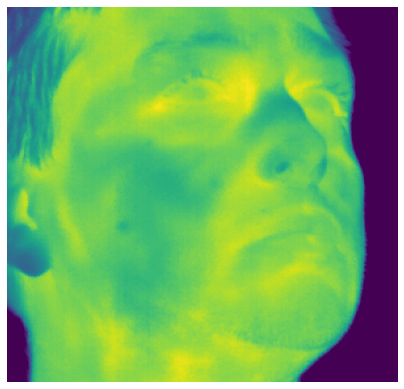

In [137]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg
from PIL import Image

print(train_images[1].view().get_figure())
t = train_images[1].view().get_figure()
tt = train_images[1]._view_landmarks_2d
ttt = train_images[1].as_PILImage()
tttt = np.array(ttt)
print(tttt)
plt.imshow(tttt)

LabelledPointUndirectedGraph: n_labels: 9, n_points: 68, n_edges: 63


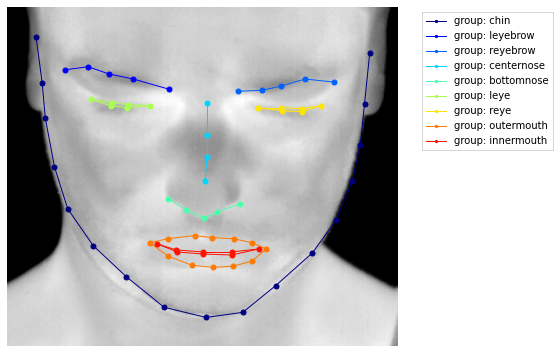

In [211]:
print(train_images[19].landmarks["LJSON"])
print(train_images[19].landmarks["LJSON"].view())
print(train_images[19].view())

TypeError: Image data of dtype object cannot be converted to float

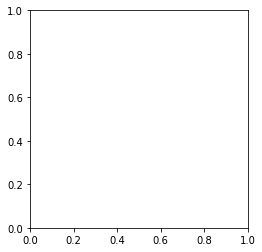

In [428]:
sum_train_images = []
sum_train_labels = []

for i in range (len(train_images)):
    temp = train_images[i].as_PILImage()
    temp = np.array(temp)
    Rx = 256/temp.shape[0]
    Ry = 256/temp.shape[1]
    temp = cv2.resize(temp, (256,256), interpolation=cv2.INTER_CUBIC)
    image = np.reshape(temp, (256,256,1))
    sum_train_images.append(np.array(image, dtype=int))
    
    temp2 = train_images[i].landmarks["LJSON"].points
    temp2 = np.array(temp2)
    for j in range(len(temp2)):
        temp2[j][0] = temp2[j][0] * Rx
        temp2[j][1] = temp2[j][1] * Ry
    sum_train_labels.append(temp2)
    
sum_train_images = np.array(sum_train_images)/255

In [442]:
class config:
    horizontal_flip = False
    rotation_augmentation = False
    brightness_augmentation = False
    shift_augmentation = False
    random_noise_augmentation = False

    rotation_angles = [12]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
    pixel_shifts = [12]    # Horizontal & vertical shift amount in pixels (includes shift from all 4 corners)

    NUM_EPOCHS = 100
    BATCH_SIZE = 64
    
    h = 256
    w = 256

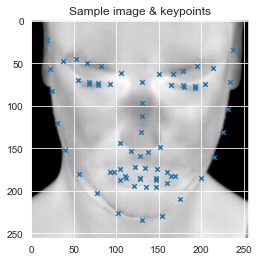

In [431]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(256,256)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[:,1], keypoint[:,0], marker='x', s=20)
    plt.title(title)

fig, axis = plt.subplots()
plot_sample(sum_train_images[19], sum_train_labels[19], axis, "Sample image & keypoints")

In [432]:
def plot_sample2(image, keypoint, axis, title):
    image = image.reshape(256,256)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

In [433]:
sum_train_labels2 = []
for k in sum_train_labels:
    temp2 = []
    for h in range (len(k)):
        temp2.append(k[h][1])
        temp2.append(k[h][0])
    sum_train_labels2.append(temp2)
sum_train_labels2 = np.array(sum_train_labels2)

In [434]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints

if config.horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(sum_train_images, sum_train_labels2)
    print("Shape of flipped_train_images:", np.shape(flipped_train_images))
    print("Shape of flipped_train_keypoints:", np.shape(flipped_train_keypoints))
    train_images = np.concatenate((sum_train_images, flipped_train_images))
    train_keypoints = np.concatenate((sum_train_labels2, flipped_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample2(flipped_train_images[19], flipped_train_keypoints[19], axis, "Horizontally Flipped") 


In [435]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in config.rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

print()

if config.rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(sum_train_images, sum_train_labels2)
    print("Shape of train_images:", np.shape(sum_train_images))
    print("Shape of rotated_train_images:", np.shape(rotated_train_images))
    print("Shape of rotated_train_keypoints:", np.shape(rotated_train_keypoints))
    train_images = np.concatenate((sum_train_images, rotated_train_images))
    train_keypoints = np.concatenate((sum_train_labels2, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample2(rotated_train_images[19], rotated_train_keypoints[19], axis, "Rotation Augmentation")

In [436]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

if config.brightness_augmentation:
    altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(sum_train_images, sum_train_labels2)
    print("Shape of altered_brightness_train_images:", np.shape(altered_brightness_train_images))
    print("Shape of altered_brightness_train_keypoints:", np.shape(altered_brightness_train_keypoints))
    train_images = np.concatenate((sum_train_images, altered_brightness_train_images))
    train_keypoints = np.concatenate((sum_train_labels2, altered_brightness_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample2(altered_brightness_train_images[19], altered_brightness_train_keypoints[19], axis, "Increased Brightness") 
    fig, axis = plt.subplots()
    plot_sample2(altered_brightness_train_images[len(altered_brightness_train_images)//2+19], altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+19], axis, "Decreased Brightness") 

In [437]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in config.pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if config.shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(sum_train_images, sum_train_labels2)
    print("Shape of shifted_train_images:", np.shape(shifted_train_images))
    print("Shape of shifted_train_keypoints:", np.shape(shifted_train_keypoints))
    print(sum_train_images.shape)
    print(shifted_train_images.shape)
    train_images = np.concatenate((sum_train_images, shifted_train_images))
    train_keypoints = np.concatenate((sum_train_labels2, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample2(shifted_train_images[19], shifted_train_keypoints[19], axis, "Shift Augmentation")

In [438]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if config.random_noise_augmentation:
    noisy_train_images = add_noise(sum_train_images)
    print("Shape of noisy_train_images:", np.shape(noisy_train_images))
    train_images = np.concatenate((sum_train_images, noisy_train_images))
    train_keypoints = np.concatenate((sum_train_labels2, sum_train_labels2))
    fig, axis = plt.subplots()
    plot_sample2(noisy_train_images[19], sum_train_labels2[19], axis, "Random Noise Augmentation")

Shape of final train_images: (2934, 256, 256, 1)
Shape of final train_keypoints: (2934, 136)

Clean Train Data: 


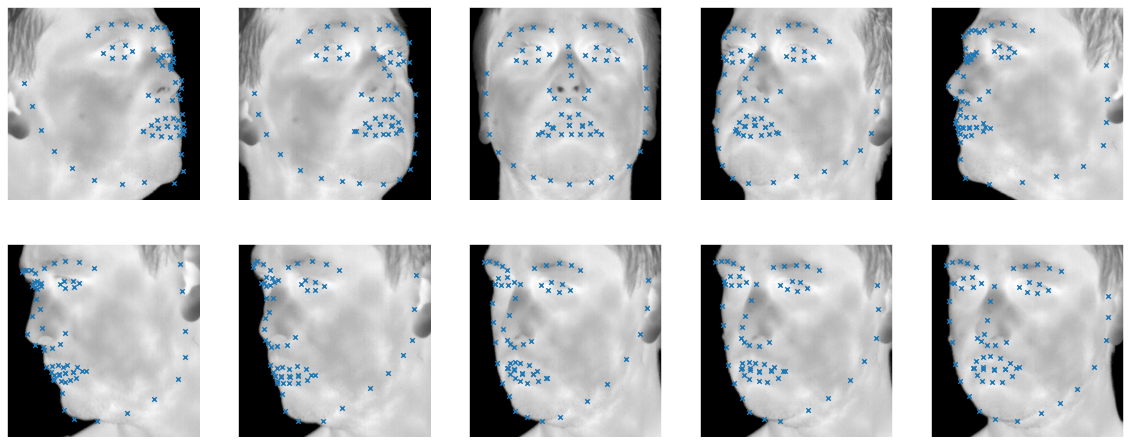

In [439]:
print("Shape of final train_images:", np.shape(sum_train_images))
print("Shape of final train_keypoints:", np.shape(sum_train_labels2))

print("\nClean Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(sum_train_images[i], sum_train_labels[i], axis, "")
plt.show()

if config.horizontal_flip:
    print("Horizontal Flip Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample2(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
    plt.show()

if config.rotation_augmentation:
    print("Rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample2(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
    plt.show()
    
if config.brightness_augmentation:
    print("Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample2(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

if config.shift_augmentation:
    print("Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample2(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()
    
if config.random_noise_augmentation:
    print("Random Noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample2(noisy_train_images[i], sum_train_labels2[i], axis, "")
    plt.show()

In [440]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, cos, pi
import cv2, os
from tqdm.auto import tqdm
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K

from tensorflow.keras import layers, callbacks, utils, applications, optimizers
from tensorflow.keras.models import Sequential, Model, load_model

In [395]:
model = Sequential()

pretrained_model = applications.MobileNet(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model.add(layers.Convolution2D(3, (1, 1), padding='same', input_shape=(96,96,1)))
model.add(layers.LeakyReLU(alpha = 0.1))
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(136))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 3)         6         
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 3, 3, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 136)               139400    
Total params: 3,368,270
Trainable params: 3,346,382
Non-trainable params: 21,888
_______________________________________

In [269]:
utils.plot_model(model, show_shapes=True, expand_nested=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [396]:
es = callbacks.EarlyStopping(
    monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1
)

model.compile(
    optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc']
)

history = model.fit(
    train_images, train_keypoints, epochs=int(1.5*config.NUM_EPOCHS), batch_size=config.BATCH_SIZE, 
    validation_split=0.05, callbacks=[es, rlp]
)

Epoch 1/150
88/88 [==============================] - 76s 848ms/step - loss: 1274.9889 - mae: 26.9925 - acc: 0.0194 - val_loss: 205.8957 - val_mae: 12.6981 - val_acc: 0.0272
Epoch 2/150
88/88 [==============================] - 75s 857ms/step - loss: 21.8499 - mae: 3.2100 - acc: 0.3489 - val_loss: 24.5384 - val_mae: 4.0101 - val_acc: 0.4082
Epoch 3/150
88/88 [==============================] - 75s 852ms/step - loss: 14.0749 - mae: 2.6026 - acc: 0.3711 - val_loss: 28.2520 - val_mae: 4.4814 - val_acc: 0.4082
Epoch 4/150
88/88 [==============================] - 76s 866ms/step - loss: 10.7175 - mae: 2.2951 - acc: 0.3840 - val_loss: 18.4216 - val_mae: 3.4353 - val_acc: 0.3163
Epoch 5/150
88/88 [==============================] - 74s 842ms/step - loss: 7.9119 - mae: 2.0110 - acc: 0.3648 - val_loss: 15.2295 - val_mae: 3.2661 - val_acc: 0.4082
Epoch 6/150
88/88 [==============================] - 76s 860ms/step - loss: 6.4420 - mae: 1.8314 - acc: 0.3609 - val_loss: 5.8585 - val_mae: 1.8872 - val_ac

c:\users\mateusz\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\mateusz\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\mateusz\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
c:\us

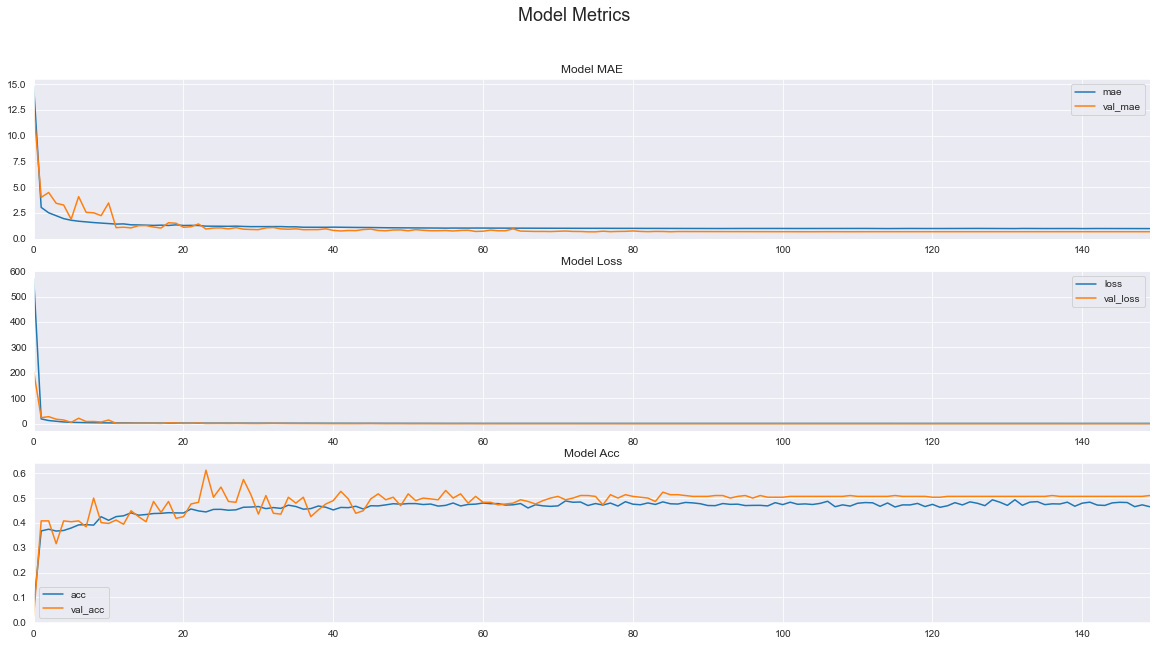

In [397]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
df = pd.DataFrame(history.history)
df[['mae', 'val_mae']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
df[['acc', 'val_acc']].plot(ax=ax[2])
ax[0].set_title('Model MAE', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
ax[2].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

In [398]:
%%time

es = callbacks.EarlyStopping(
    monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1
)


model.compile(
    optimizer=optimizers.Adam(learning_rate=history.history['lr'][-1]), loss='mean_squared_error', metrics=['mae', 'acc']
)

history = model.fit(
    train_images, train_keypoints, epochs=2*config.NUM_EPOCHS, batch_size=config.BATCH_SIZE, callbacks=[es, rlp]
)

Epoch 1/200
92/92 [==============================] - 86s 914ms/step - loss: 1.6551 - mae: 0.9939 - acc: 0.4746
Epoch 2/200
92/92 [==============================] - 85s 925ms/step - loss: 1.6220 - mae: 0.9810 - acc: 0.4745
Epoch 3/200
92/92 [==============================] - 85s 919ms/step - loss: 1.5733 - mae: 0.9690 - acc: 0.4648
Epoch 4/200
92/92 [==============================] - 85s 922ms/step - loss: 1.6091 - mae: 0.9777 - acc: 0.4685
Epoch 5/200
92/92 [==============================] - 85s 919ms/step - loss: 1.6591 - mae: 0.9907 - acc: 0.4706
Epoch 6/200
92/92 [==============================] - 86s 930ms/step - loss: 1.5934 - mae: 0.9764 - acc: 0.4646
Epoch 7/200
92/92 [==============================] - 85s 929ms/step - loss: 1.6470 - mae: 0.9848 - acc: 0.4658
Epoch 8/200
92/92 [==============================] - 86s 930ms/step - loss: 1.6323 - mae: 0.9873 - acc: 0.4834

Epoch 00008: ReduceLROnPlateau reducing learning rate to 4.768371808516747e-10.
Epoch 9/200
92/92 [============

c:\users\mateusz\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\mateusz\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\mateusz\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
c:\us

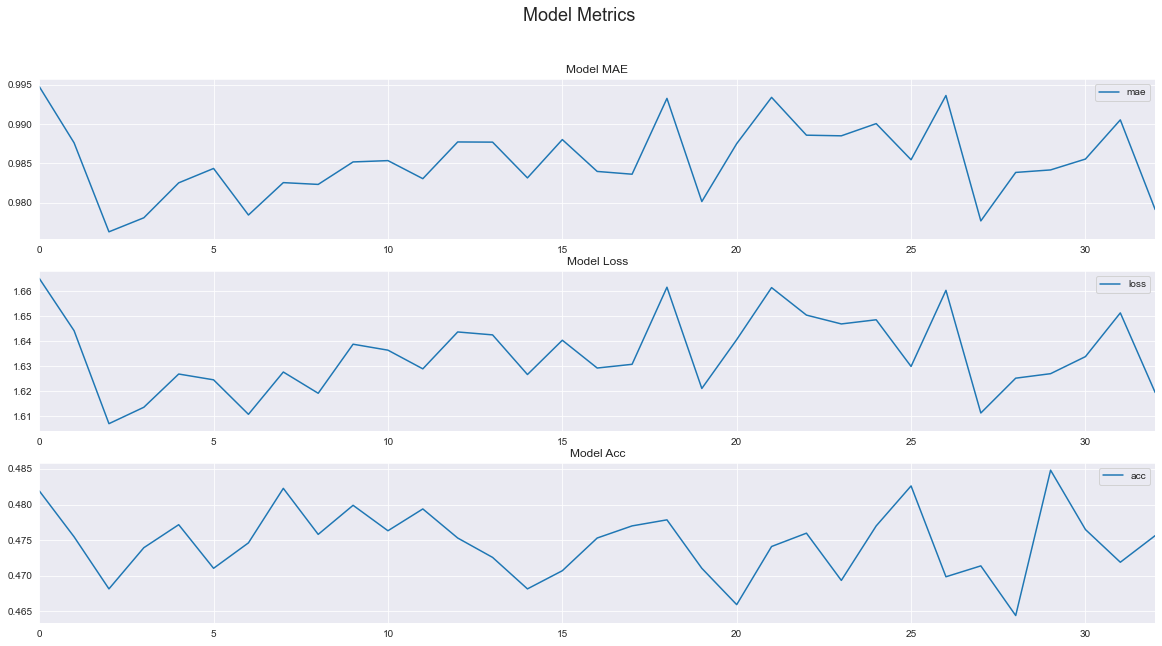

In [399]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
df = pd.DataFrame(history.history)
df[['mae']].plot(ax=ax[0])
df[['loss']].plot(ax=ax[1])
df[['acc']].plot(ax=ax[2])
ax[0].set_title('Model MAE', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
ax[2].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

In [420]:
TEST_IMG_PATH = "testimage.png" # "/home/temp/schock/Infrared/Databases/IR_HPE_Colette/001/image_00000.png" 
testimages = []

temp = mio.import_image(TEST_IMG_PATH)
    
if temp.n_channels > 2:
    temp = temp.as_greyscale()
        
testimages.append(temp)


for i in range (len(testimages)):
    temp = testimages[i].as_PILImage()
    temp = np.array(temp)
    Rx = 96/temp.shape[0]
    Ry = 96/temp.shape[1]
    temp = cv2.resize(temp, (96,96), interpolation=cv2.INTER_CUBIC)
    image = np.reshape(temp, (96,96,1))
    testimages = []
    testimages.append(np.array(image, dtype=int))
    
testimages = np.array(testimages)/255



test_preds = model.predict(testimages)

IndexError: index 1 is out of bounds for axis 0 with size 1

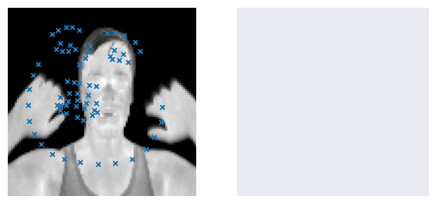

In [424]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample2(testimages[i], test_preds[i], axis, "")

In [425]:
feature_names = list(idlookup_data['FeatureName'])
image_ids = list(idlookup_data['ImageId']-1)
row_ids = list(idlookup_data['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))
    
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(test_preds[x][y])
    
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('submission.csv',index = False)

NameError: name 'idlookup_data' is not defined

In [445]:
# import the necessary packages

from imutils import paths
import imutils
import json
import time
import cv2
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

In [446]:
input_size = (config.h, config.w, 1)
inputs = keras.Input(input_size)

# downsampling

conv1 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv1)

pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv2)

pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv3)

pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv4)

pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(1024, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv5)

drop5 = Dropout(0.5)(conv5)

# upsampling

up6 = Conv2DTranspose(512, 3, strides = (2,2), activation='relu', padding = 'same', kernel_initializer='glorot_normal') (drop5)
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv6)

up7 = Conv2DTranspose(256, 3, strides = (2,2), activation='relu', padding = 'same', kernel_initializer='glorot_normal') (conv6)
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv7)

up8 = Conv2DTranspose(128, 3, strides = (2,2), activation='relu', padding = 'same', kernel_initializer='glorot_normal') (conv7)
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv8)

up9 = Conv2DTranspose(64, 3, strides = (2,2), activation='relu', padding = 'same', kernel_initializer='glorot_normal') (conv8)
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='glorot_normal')(conv9)

drop9 = Dropout(0.5)(conv9)

conv10 = Conv2D(1, 1, activation = 'sigmoid', padding = 'same', kernel_initializer='glorot_normal')(drop9)

u_net = keras.Model(inputs = inputs, outputs = conv10)

In [447]:
u_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 256, 256, 64) 640         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_6[0][0]                   
______________________________________________________________________________________________

In [448]:
# create checkpoint
checkpoint_dir = "checkpoints-sf-0-1"
callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir+"/landmark", 
                                                      save_weights_only=True, 
                                                      save_best_only=True,monitor='val_loss',
                                                      verbose=1)

# initializing callback function
callbacks0 = [callback_checkpoint]

if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.mkdir(checkpoint_dir)
    print("Checkpoint directory created: {}".format(checkpoint_dir))

# if checkpoint exists, load the weights
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    print("Checkpoint found: {}, restoring...".format(latest_checkpoint))
    u_net.load_weights(latest_checkpoint)
    print("Checkpoint restored: {}".format(latest_checkpoint))
else:
    print("Checkpoint not found. Model weights will be initialized randomly.")

Checkpoint directory created: checkpoints-sf-0-1
Checkpoint not found. Model weights will be initialized randomly.


In [449]:
# learning rate scheduler

def lr_schedule( epoch ):

    lr = 5e-4
    
    if epoch >= 10:
        lr = 1e-4

    print("Learning rate: ", lr)
    return lr

In [450]:
# setting learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# setting early stopping 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks0.append(lr_scheduler)
callbacks0.append(es)

In [451]:
# compile
u_net.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(lr_schedule(0)))

Learning rate:  0.0005


In [ ]:
# train
history = u_net.fit(img_train, bmask_train, validation_data=(img_val, bmask_val), shuffle=True, batch_size=32, epochs=20, callbacks=callbacks0)